# Probabilistic ML as Gaussian Processes
#### Using molecular configurations as input to predict energyand forces

### Experiment 1

The first experiment I ran was to run the schnet model using seperate sets of training and testing data. I used the Alanine molecule configurations as the training data and the Glycine molecule configurations as the testing data.

In [4]:
# loading the libraries

import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mean
from torch.utils.data import DataLoader

# importing from the local directory

import sys
sys.path.append("../..")

from models.schnet.schnet import SchNetWrap
from data.TorsiAA.TorsiAADataset import TorsiAADataset

In [3]:
# defining the loss functions to be used in training the model

def EnergyLoss(pred, label):
    p, l = pred["E"].squeeze(), label["E"].squeeze()
    mae = torch.nn.L1Loss()
    return mae(p, l)

def PosForceLoss(pred, label):
    p, l = pred["F"].squeeze(), label["F"].squeeze()
    mae = torch.nn.L1Loss()
    return [mae(p[i][j], l[i][j]) for i in range(len(p)) for j in range(3)]

def AtomForceLoss(pred, label):
    p, l = pred["F"].squeeze(), label["F"].squeeze()
    p = p.reshape((-1, 3))
    l = l.reshape((-1, 3))
    mae = torch.nn.L1Loss()
    return torch.Tensor([mae(p[i], l[i]) for i in range(len(p))])

def EnergyForceLoss(pred, label):
    E = EnergyLoss(pred, label)
    F = AtomForceLoss(pred, label)
    return E + 30*torch.mean(F)

In [4]:
loss_fn = EnergyForceLoss
device = "cuda"
save_path = "checkpoints"
save_freqency = 10
model = SchNetWrap().to(device)

# loading the data

dataset = TorsiAADataset(path="../../data/TorsiAA/TorsiAA_initial_geometries/Ala_mopac_rotations.pickle")

Number of samples 1171


In [4]:
test_dataset = TorsiAADataset(path="../../data/TorsiAA/TorsiAA_initial_geometries/Gly_mopac_rotations.pickle")

Number of samples 1129


In [5]:
# function for training the model with LR Scheduling

def scheduledTrain(batch_size, learning_rate, weight_decay, optimizer, epochs):

    train_dataloader = DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    collate_fn=dataset.collate, num_workers=1)

    optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)
        
    ep = []
    l = []

    for e in tqdm(range(epochs)):
        losses = []
        for data, label in train_dataloader:
            data = {i:v.to(device) for i, v in data.items()}
            label = {i:v.to(device) for i, v in label.items()}

            pred = model(data)
            loss = loss_fn(pred, label)
            
            model.zero_grad()
            loss.backward()
            optimizer.step()

            losses += [loss.to("cpu").item()]

        scheduler.step(mean(losses))
        epoch_losses = mean(losses)
        
        ep.append(e)
        l.append(epoch_losses)

        if e%(save_freqency) == 0 or e == epochs:
            print("Average loss", epoch_losses)

    return model, ep, l        

  0%|          | 1/300 [00:01<08:32,  1.71s/it]

Average loss 1283.62451171875


  4%|▎         | 11/300 [00:12<05:05,  1.06s/it]

Average loss 1267.0979370117188


  7%|▋         | 21/300 [00:22<04:50,  1.04s/it]

Average loss 659.63017578125


 10%|█         | 31/300 [00:33<04:49,  1.08s/it]

Average loss 555.2968078613281


 14%|█▎        | 41/300 [00:44<04:36,  1.07s/it]

Average loss 430.28798828125


 17%|█▋        | 51/300 [00:54<04:28,  1.08s/it]

Average loss 391.5638000488281


 20%|██        | 61/300 [01:05<04:11,  1.05s/it]

Average loss 358.87388305664064


 24%|██▎       | 71/300 [01:16<04:11,  1.10s/it]

Average loss 334.5548400878906


 27%|██▋       | 81/300 [01:26<03:59,  1.10s/it]

Average loss 318.1836364746094


 30%|███       | 91/300 [01:37<03:43,  1.07s/it]

Average loss 294.79234008789064


 34%|███▎      | 101/300 [01:48<03:36,  1.09s/it]

Average loss 286.9070739746094


 37%|███▋      | 111/300 [01:59<03:21,  1.07s/it]

Average loss 276.8730834960937


 40%|████      | 121/300 [02:09<03:11,  1.07s/it]

Average loss 266.7549346923828


 44%|████▎     | 131/300 [02:20<02:54,  1.03s/it]

Average loss 256.83897399902344


 47%|████▋     | 141/300 [02:30<02:47,  1.05s/it]

Average loss 248.5693389892578


 50%|█████     | 151/300 [02:41<02:38,  1.07s/it]

Average loss 241.81331787109374


 54%|█████▎    | 161/300 [02:52<02:32,  1.10s/it]

Average loss 235.69802856445312


 57%|█████▋    | 171/300 [03:03<02:18,  1.08s/it]

Average loss 229.208544921875


 60%|██████    | 181/300 [03:13<02:08,  1.08s/it]

Average loss 222.24277954101564


 64%|██████▎   | 191/300 [03:24<01:56,  1.07s/it]

Average loss 216.81387329101562


 67%|██████▋   | 201/300 [03:35<01:43,  1.04s/it]

Average loss 203.08819580078125


 70%|███████   | 211/300 [03:45<01:33,  1.06s/it]

Average loss 197.92819213867188


 74%|███████▎  | 221/300 [03:56<01:25,  1.09s/it]

Average loss 207.92868347167968


 76%|███████▌  | 228/300 [04:03<01:15,  1.05s/it]

Epoch   228: reducing learning rate of group 0 to 1.0000e-05.


 77%|███████▋  | 231/300 [04:06<01:10,  1.02s/it]

Average loss 173.12840270996094


 80%|████████  | 241/300 [04:17<01:04,  1.10s/it]

Average loss 173.182666015625


 82%|████████▏ | 247/300 [04:23<00:58,  1.10s/it]

Epoch   247: reducing learning rate of group 0 to 1.0000e-06.


 84%|████████▎ | 251/300 [04:28<00:52,  1.06s/it]

Average loss 169.90318298339844


 87%|████████▋ | 261/300 [04:38<00:42,  1.09s/it]

Average loss 170.20597229003906


 90%|█████████ | 271/300 [04:49<00:30,  1.05s/it]

Average loss 169.5553466796875


 94%|█████████▎| 281/300 [05:00<00:20,  1.06s/it]

Average loss 169.62701721191405


 97%|█████████▋| 291/300 [05:10<00:09,  1.04s/it]

Average loss 169.56622009277345


100%|██████████| 300/300 [05:20<00:00,  1.07s/it]


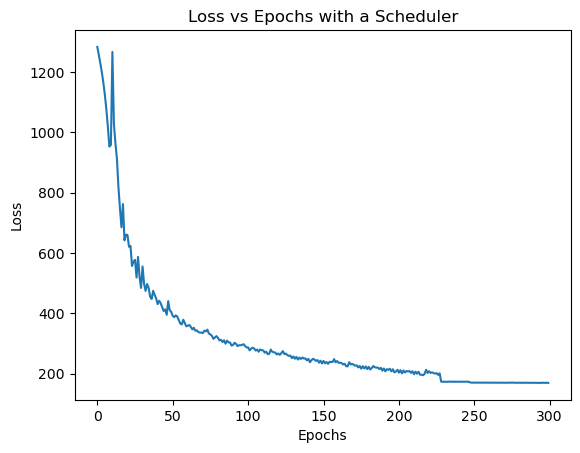

In [6]:
batch_size = 256
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = torch.optim.SGD
epochs = 300

sModel, se, sl = scheduledTrain(batch_size, learning_rate, weight_decay, optimizer, epochs)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs with a Scheduler")
plt.plot(se,sl)
plt.show()

In [9]:
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                collate_fn=dataset.collate, num_workers=1)

losses = []
test_loss = []

sModel.eval()

for data, label in test_dataloader:
    data = {i:v.to(device) for i, v in data.items()}
    label = {i:v.to(device) for i, v in label.items()}
    pred = model(data)
    loss = loss_fn(pred, label)
    
    losses+= [loss.to("cpu").item()]
test_loss += [mean(losses)]

print("Average loss on unseen data:", mean(test_loss))

Average loss on unseen data: 346.8485046386719


### Experiment 2

The next experiment I tried was to use the schnet as the prior for a GP model, but I was unsuccessful in running the experiment.

I mostly experimented using GPs for the next experiments.  I used synthetic data with 2D inputs and 3D outputs. The first output is the 'energy' and the other two are the 'forces' in the 2 input dimensions.

First, I checked how a multitask kernel would perform on this task. This kernel is similar to a vanilla kernel with multiple dimensions assigned to the mean function and the kernel. I used a multitask Gaussian marginal log likelihood to model the data with an RBF kernel.

In [2]:
import numpy as np
import math
import jax.numpy as jnp
from jax import jacrev, jacfwd
from torch.autograd import Variable

# importing from the local directory
from directionalvi.utils.synthetic_functions import *
from directionalvi.utils.load_data import *

def generate_synthetic_data(func_name, n_train, n_test, model, **args):
    func = eval(f"{func_name}_with_deriv")()
    dim = func.dim
    n=n_train
    n = int(n_train/(dim+1)) if model=="gradGP" else n
    print(n)
    x, y, info_dict = load_synthetic_data(func, n+n_test, **args)
    train_x = x[:n, :].numpy()
    test_x = x[n:, :].numpy()
    train_y = y[:n, ...].numpy()
    test_y = y[n:, ...].numpy()
    
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = generate_synthetic_data("Branin", 20, 5, "Hello", seed=0, derivative=True)
train_x = Variable(torch.from_numpy(train_x).float())
train_y = Variable(torch.from_numpy(train_y).float())
test_x = Variable(torch.from_numpy(test_x).float())
test_y = Variable(torch.from_numpy(test_y).float())

20


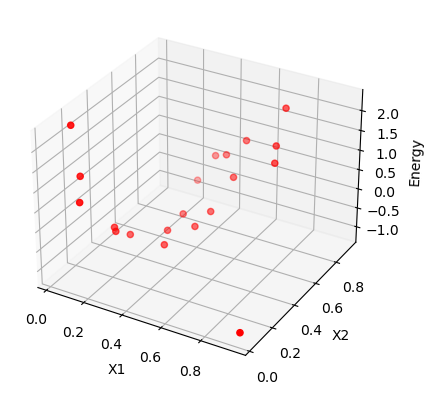

In [4]:
n_train = train_x.shape[0]

#plot the energies in 3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_x[:, 0], train_x[:, 1], train_y[:, 0], c='r', marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Energy')
plt.show()

In [5]:
# create a model using gpytorch with a multioutput kernel

import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel, MultitaskKernel
from gpytorch.means import MultitaskMean, ConstantMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel=RBFKernel()):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MultitaskMean(ConstantMean(), num_tasks=3)
        self.covar_module = MultitaskKernel(ScaleKernel(kernel), num_tasks=3, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
kernel = RBFKernel()
likelihood = MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 5.988
Iter 2/100 - Loss: 4.763
Iter 3/100 - Loss: 3.867
Iter 4/100 - Loss: 3.249
Iter 5/100 - Loss: 2.842
Iter 6/100 - Loss: 2.578
Iter 7/100 - Loss: 2.408
Iter 8/100 - Loss: 2.302
Iter 9/100 - Loss: 2.241
Iter 10/100 - Loss: 2.209
Iter 11/100 - Loss: 2.195
Iter 12/100 - Loss: 2.190
Iter 13/100 - Loss: 2.191
Iter 14/100 - Loss: 2.193
Iter 15/100 - Loss: 2.194
Iter 16/100 - Loss: 2.192
Iter 17/100 - Loss: 2.186
Iter 18/100 - Loss: 2.176
Iter 19/100 - Loss: 2.162
Iter 20/100 - Loss: 2.145
Iter 21/100 - Loss: 2.125
Iter 22/100 - Loss: 2.103
Iter 23/100 - Loss: 2.079
Iter 24/100 - Loss: 2.056
Iter 25/100 - Loss: 2.032
Iter 26/100 - Loss: 2.010
Iter 27/100 - Loss: 1.989
Iter 28/100 - Loss: 1.970
Iter 29/100 - Loss: 1.953
Iter 30/100 - Loss: 1.938
Iter 31/100 - Loss: 1.925
Iter 32/100 - Loss: 1.915
Iter 33/100 - Loss: 1.906
Iter 34/100 - Loss: 1.897
Iter 35/100 - Loss: 1.889
Iter 36/100 - Loss: 1.881
Iter 37/100 - Loss: 1.871
Iter 38/100 - Loss: 1.859
Iter 39/100 - Loss: 1

In [6]:
# predict on test set
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(test_x))

pred.mean

tensor([[-0.3339, -1.4920, -0.0784],
        [-0.0556, -1.2214, -2.0257],
        [-0.0174, -9.5141, -4.3525],
        [ 1.8047,  2.2670,  5.6615],
        [-0.9620,  0.9074, -0.0673]])

In [7]:
# calculate RMSE for all three outputs individually

def rmse(pred, test_y):
    return np.sqrt(np.mean((pred.detach().numpy() - test_y.numpy()) ** 2))

rmse_e = rmse(pred.mean[:,0], test_y[:,0])
rmse_f1 = rmse(pred.mean[:,1], test_y[:,1])
rmse_f2 = rmse(pred.mean[:,2], test_y[:,2])

print('RMSE for Energy: ', rmse_e)
print('RMSE for Force 1: ', rmse_f1)
print('RMSE for Force 2: ', rmse_f2)

RMSE for Energy:  0.708459
RMSE for Force 1:  2.9264905
RMSE for Force 2:  0.6667718


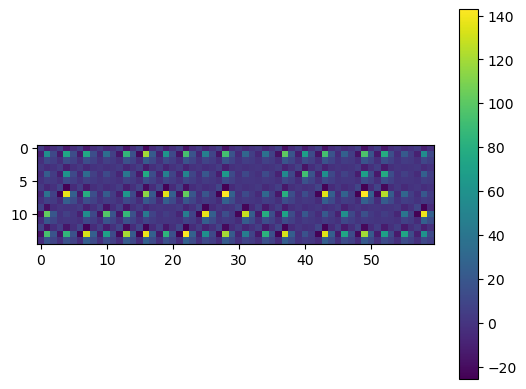

In [8]:
# plot the kernel(test, train)

plt.imshow(model.covar_module(test_x, train_x).detach().numpy())
plt.colorbar()
plt.show()

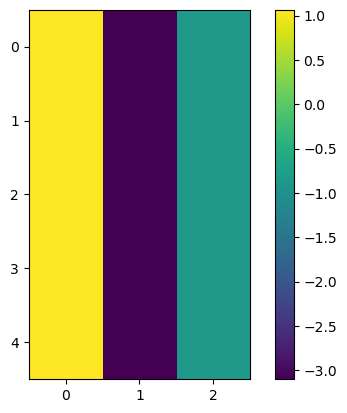

In [9]:
#plot the mean function for the test data

plt.imshow(model.mean_module(test_x).detach().numpy())
plt.colorbar()
plt.show()

### Experiment 3

Next, I trained a model using the same sunthetic data using an RBFKernelGrad which models the covariance between the values and partial derivatives for inputs by adding two gradient blocks and one Hessian block to the RBF kernel. I used a multitask Gaussian marginal log likelihood to model the data here as well.

In [10]:
# create a GP with RBFKernelGrad

from gpytorch.kernels import RBFKernelGrad
from gpytorch.means import ConstantMeanGrad
from gpytorch.models import ExactGP

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMeanGrad()
        self.covar_module = ScaleKernel(RBFKernelGrad(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal(mean_x, covar_x)

def train_gp(train_x, train_y, likelihood, model, n_iter=100):
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    training_iter = n_iter
    for i in tqdm(range(training_iter)):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
    return model, likelihood

In [11]:
ndim=2
n_train = train_x.shape[0]

likelihood = MultitaskGaussianLikelihood(num_tasks=3)
model = GPModel(train_x, train_y, likelihood)
model, likelihood = train_gp(train_x, train_y, likelihood, model, n_iter=100)

 21%|██        | 21/100 [00:00<00:00, 106.55it/s]

Iter 1/100 - Loss: 4.408
Iter 2/100 - Loss: 3.928
Iter 3/100 - Loss: 3.540
Iter 4/100 - Loss: 3.229
Iter 5/100 - Loss: 2.978
Iter 6/100 - Loss: 2.770
Iter 7/100 - Loss: 2.593
Iter 8/100 - Loss: 2.441
Iter 9/100 - Loss: 2.313
Iter 10/100 - Loss: 2.210
Iter 11/100 - Loss: 2.130
Iter 12/100 - Loss: 2.070
Iter 13/100 - Loss: 2.026
Iter 14/100 - Loss: 1.994
Iter 15/100 - Loss: 1.971
Iter 16/100 - Loss: 1.956
Iter 17/100 - Loss: 1.945
Iter 18/100 - Loss: 1.938
Iter 19/100 - Loss: 1.933
Iter 20/100 - Loss: 1.929
Iter 21/100 - Loss: 1.924


 34%|███▍      | 34/100 [00:00<00:00, 115.36it/s]

Iter 22/100 - Loss: 1.918
Iter 23/100 - Loss: 1.910
Iter 24/100 - Loss: 1.900
Iter 25/100 - Loss: 1.888
Iter 26/100 - Loss: 1.873
Iter 27/100 - Loss: 1.857
Iter 28/100 - Loss: 1.840
Iter 29/100 - Loss: 1.821
Iter 30/100 - Loss: 1.801
Iter 31/100 - Loss: 1.781
Iter 32/100 - Loss: 1.760
Iter 33/100 - Loss: 1.738
Iter 34/100 - Loss: 1.716
Iter 35/100 - Loss: 1.694
Iter 36/100 - Loss: 1.672
Iter 37/100 - Loss: 1.650
Iter 38/100 - Loss: 1.628
Iter 39/100 - Loss: 1.607
Iter 40/100 - Loss: 1.586
Iter 41/100 - Loss: 1.565


 57%|█████▋    | 57/100 [00:00<00:00, 94.87it/s] 

Iter 42/100 - Loss: 1.544
Iter 43/100 - Loss: 1.523
Iter 44/100 - Loss: 1.503
Iter 45/100 - Loss: 1.483
Iter 46/100 - Loss: 1.463
Iter 47/100 - Loss: 1.442
Iter 48/100 - Loss: 1.422
Iter 49/100 - Loss: 1.401
Iter 50/100 - Loss: 1.381
Iter 51/100 - Loss: 1.360
Iter 52/100 - Loss: 1.338
Iter 53/100 - Loss: 1.317
Iter 54/100 - Loss: 1.295
Iter 55/100 - Loss: 1.273
Iter 56/100 - Loss: 1.250
Iter 57/100 - Loss: 1.228
Iter 58/100 - Loss: 1.205
Iter 59/100 - Loss: 1.183
Iter 60/100 - Loss: 1.161
Iter 61/100 - Loss: 1.138
Iter 62/100 - Loss: 1.117
Iter 63/100 - Loss: 1.095
Iter 64/100 - Loss: 1.074


 83%|████████▎ | 83/100 [00:00<00:00, 110.64it/s]

Iter 65/100 - Loss: 1.052
Iter 66/100 - Loss: 1.031
Iter 67/100 - Loss: 1.010
Iter 68/100 - Loss: 0.989
Iter 69/100 - Loss: 0.968
Iter 70/100 - Loss: 0.947
Iter 71/100 - Loss: 0.926
Iter 72/100 - Loss: 0.904
Iter 73/100 - Loss: 0.883
Iter 74/100 - Loss: 0.862
Iter 75/100 - Loss: 0.840
Iter 76/100 - Loss: 0.819
Iter 77/100 - Loss: 0.798
Iter 78/100 - Loss: 0.776
Iter 79/100 - Loss: 0.755
Iter 80/100 - Loss: 0.734
Iter 81/100 - Loss: 0.713
Iter 82/100 - Loss: 0.691
Iter 83/100 - Loss: 0.670
Iter 84/100 - Loss: 0.648
Iter 85/100 - Loss: 0.627
Iter 86/100 - Loss: 0.606
Iter 87/100 - Loss: 0.584
Iter 88/100 - Loss: 0.563


100%|██████████| 100/100 [00:00<00:00, 101.25it/s]

Iter 89/100 - Loss: 0.541
Iter 90/100 - Loss: 0.520
Iter 91/100 - Loss: 0.498
Iter 92/100 - Loss: 0.477
Iter 93/100 - Loss: 0.455
Iter 94/100 - Loss: 0.434
Iter 95/100 - Loss: 0.412
Iter 96/100 - Loss: 0.391
Iter 97/100 - Loss: 0.369
Iter 98/100 - Loss: 0.348
Iter 99/100 - Loss: 0.327
Iter 100/100 - Loss: 0.306


In [12]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(test_x))

print(pred.mean)

tensor([[-1.1347,  0.3335,  0.4721],
        [-1.0528,  1.0298, -0.8204],
        [-0.0573, -9.6100, -4.3841],
        [ 1.0573, -3.7564,  5.7395],
        [-0.9344,  1.6126, -0.0688]])


In [13]:
# calculate RMSE for all three outputs individually

def rmse(pred, test_y):
    return np.sqrt(np.mean((pred.detach().numpy() - test_y.numpy()) ** 2))

rmse_e = rmse(pred.mean[:,0], test_y[:,0])
rmse_f1 = rmse(pred.mean[:,1], test_y[:,1])
rmse_f2 = rmse(pred.mean[:,2], test_y[:,2])

print('RMSE for Energy: ', rmse_e)
print('RMSE for Force 1: ', rmse_f1)
print('RMSE for Force 2: ', rmse_f2)

RMSE for Energy:  0.05421732
RMSE for Force 1:  0.20389366
RMSE for Force 2:  0.09439141


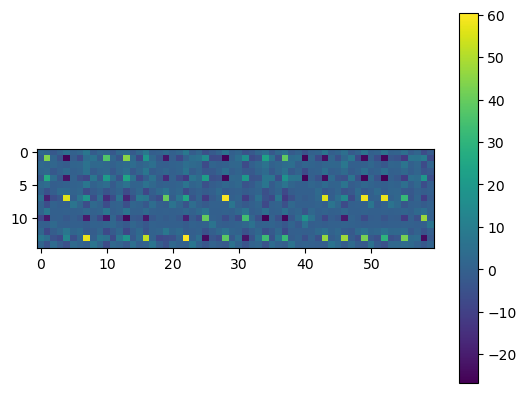

In [14]:
# plot the kernel

plt.imshow(model.covar_module(test_x, train_x).detach().numpy())
plt.colorbar()
plt.show()

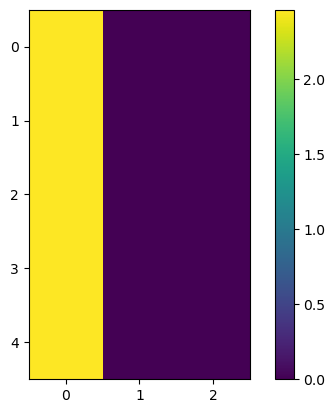

In [15]:
#plot the mean function

plt.imshow(model.mean_module(test_x).detach().numpy())
plt.colorbar()
plt.show()

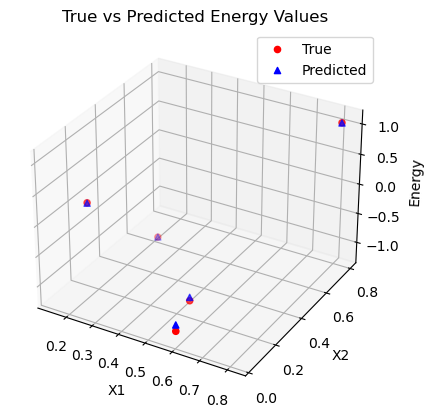

In [16]:
# plot the pred_0 with test_y_0 values in 3d

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_x[:,0], test_x[:,1], test_y[:,0], c='r', marker='o')
ax.scatter(test_x[:,0], test_x[:,1], pred.mean[:,0], c='b', marker='^')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Energy')
ax.legend(['True', 'Predicted'])
ax.title.set_text('True vs Predicted Energy Values')
plt.show()

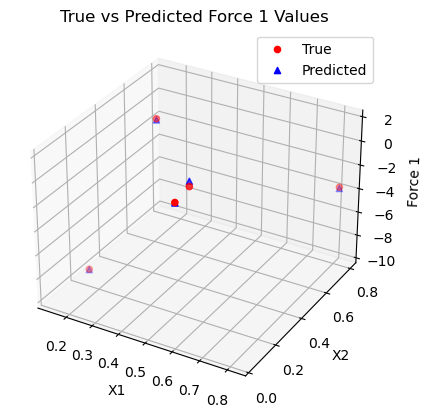

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_x[:,0], test_x[:,1], test_y[:,1], c='r', marker='o')
ax.scatter(test_x[:,0], test_x[:,1], pred.mean[:,1], c='b', marker='^')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Force 1')
ax.legend(['True', 'Predicted'])
ax.title.set_text('True vs Predicted Force 1 Values')
plt.show()

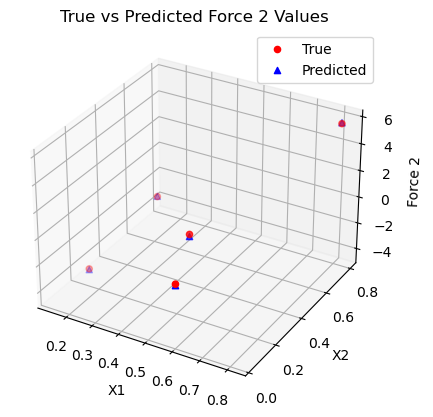

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_x[:,0], test_x[:,1], test_y[:,2], c='r', marker='o')
ax.scatter(test_x[:,0], test_x[:,1], pred.mean[:,2], c='b', marker='^')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Force 2')
ax.legend(['True', 'Predicted'])
ax.title.set_text('True vs Predicted Force 2 Values')
plt.show()

### Experiment 4

As we can see in the three charts and the individual RMSEs above, The RBFKernelGrad performs better and is able to closely map all the outputs with low erroe rates.

After running these experiments, I was discussing my approch with a fellow classmate, Elliot K., and with his help, I implemented a GP model with a kernel that models the partial derivatives as well as the energy. This kernel is similar to the RBFKernelGrad, but it is implemented in a different way. I have implemented this model from scratch using JAX. We have set the prior/mean function equal to zero, so no mean function definition is required.

For this final experiment, I split the 20 training inputs into 15 training inputs and 5 validation inputs to be used while training the model, then I optimized the lengthscale of the RBF kernel using the same training and validation data points. And finally, I tested the optimal model on the original test dataset with 5 datapoints.

20


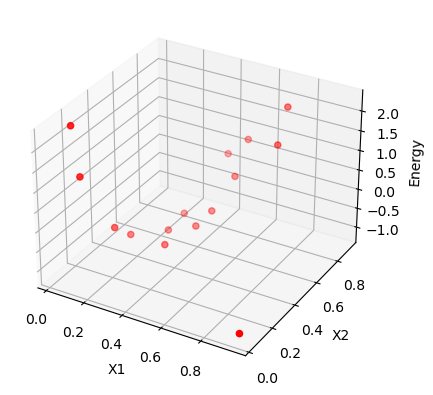

In [5]:
train_x, test_x, train_y, test_y = generate_synthetic_data("Branin", 20, 5, "Hello", seed=0, derivative=True)

#split the training data into train and validation

n_train = train_x.shape[0]
train_x, val_x = train_x[:int(n_train*.75), :], train_x[int(n_train*.25):, :]
train_y, val_y = train_y[:int(n_train*.75), :], train_y[int(n_train*.25):, :]

#plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_x[:, 0], train_x[:, 1], train_y[:, 0], c='r', marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Energy')
plt.show()

In [6]:
#Kernel function

def rbf(x1, x2, L = 1.0) -> float:
    #Inputs:
    #x1 = 1xd vector (1 sample)
    #x2 = 1xd vector (1 sample)
    
    prefactor = -(x1 - x2)**2
    factor = jnp.exp(prefactor/ (2*(L**2)) )
    return jnp.dot(factor, factor)

In [7]:
#Creating an individual block
def inline_hessian(x1, x2, L=1.0, k = rbf, sigma2 = 1e-6):
    kern = jnp.array([k(x1, x2)])
    jac2 = jacrev(k, argnums=1)(x1, x2)
    f_jac1 = jacrev(k, argnums=0)
    jac1 = f_jac1(x1, x2).reshape(-1, 1)
    hes = jacfwd(f_jac1, argnums=1)(x1, x2)

    # Put everything together
    top = jnp.concatenate([kern, jac2]).reshape(1, -1)
    bot = jnp.concatenate([jac1, hes], axis=1)
    K = jnp.concatenate([top, bot])
    return K

#Bringing it all together
def deriv_kernel(X1, X2, L=1.0, k = rbf, sigma2 = 1e-6):
    return jnp.concatenate([jnp.concatenate([ inline_hessian(x1, x2) \
                                for x2 in X2], axis=1) for x1 in X1])

In [8]:
#mean_Xs = mean_vec_deriv(mu, train_x)
ndim=2
n_train = train_x.shape[0]
n_val = val_x.shape[0]
modified_train_y = train_y.reshape([n_train*(ndim+1), 1])
modified_val_y = val_y.reshape([n_val*(ndim+1), 1])

#Our GP function, we just need to switch out the kernel depending on the GP

def GP(x_train, x_test, y_train, y_test, k, vec_cov_mat, L = 1.0, sigma2 = 1e-6) -> jnp.DeviceArray:
    #Inputs:
    #X_{} = data
    #y_{} = predictive output
    #k = kernel function
    #cov_mat = covariance matrix function
    #L = lengthscale
    #sigma = noise
    
    #Outputs:
    #Posterior mean = np.ndarray of y_hat
    
    K_test_train = deriv_kernel(x_test, x_train)
    K_train_train = deriv_kernel(x_train, x_train)
    K_train_train += sigma2 * jnp.eye(K_train_train.shape[0])
    chol_kxx = np.linalg.cholesky(K_train_train)
    w = jnp.linalg.solve(jnp.transpose(chol_kxx), jnp.linalg.solve(chol_kxx, y_train))   
    
    return ((K_test_train) @ w)

In [9]:
prediction = GP(train_x, val_x, modified_train_y, modified_val_y, rbf, deriv_kernel, 1.0)
print(prediction.shape)

(45, 1)


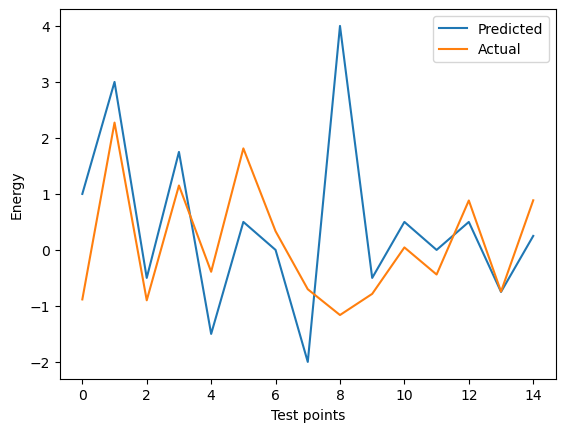

In [11]:
#Plot energy predictions of the validation data
idx = ndim + 1
plt.plot(range(len(prediction[::idx])), prediction[::idx])
plt.plot(range(len(modified_val_y[::idx])), modified_val_y[::idx])
plt.xlabel("Test points")
plt.ylabel("Energy")
plt.legend(["Predicted", "Actual"])
plt.show()

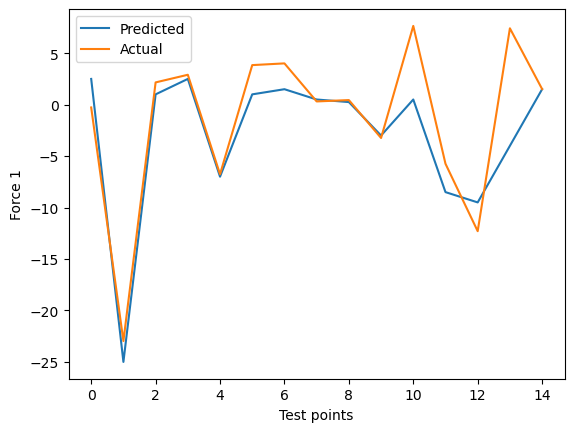

In [12]:
#Force 1 predictions of the validation data
plt.plot(range(len(prediction[1::idx])), prediction[1::idx])
plt.plot(range(len(modified_val_y[1::idx])), modified_val_y[1::idx])
plt.xlabel("Test points")
plt.ylabel("Force 1")
plt.legend(["Predicted", "Actual"])
plt.show()

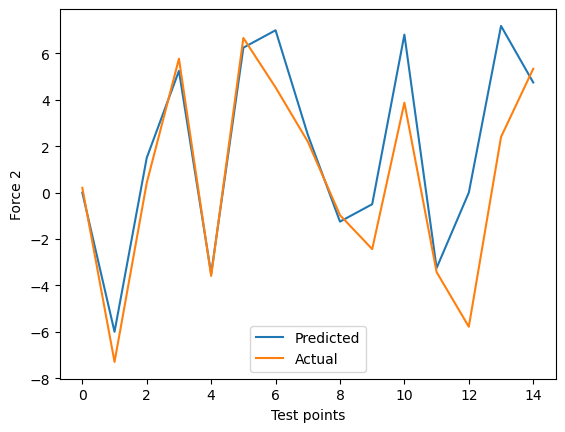

In [13]:
#Force 2 predictions of the validation data
plt.plot(range(len(prediction[2::idx])), prediction[2::idx])
plt.plot(range(len(modified_val_y[2::idx])), modified_val_y[2::idx])
plt.xlabel("Test points")
plt.ylabel("Force 2")
plt.legend(["Predicted", "Actual"])
plt.show()

In [14]:
#optimizing the lengthscale

lengthscale = np.linspace(0, 1, 50)
best_lengthscale = 0.
best_error = 1000

for i in tqdm(lengthscale):
    prediction = GP(train_x, val_x, modified_train_y, modified_val_y, rbf, deriv_kernel, i)
    error = np.linalg.norm(prediction - modified_val_y)
    if error < best_error:
        best_error = error
        best_lengthscale = i

print(best_lengthscale)

100%|██████████| 50/50 [09:30<00:00, 11.42s/it]

0.0


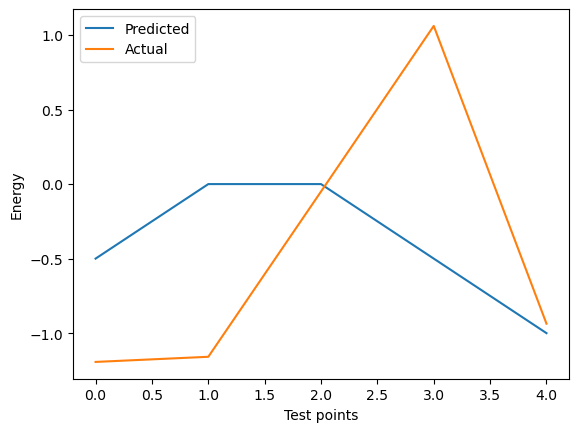

In [15]:
modified_test_y = test_y.reshape([test_y.shape[0]*(ndim+1), 1])
test_pred = GP(train_x, test_x, modified_train_y, modified_test_y, rbf, deriv_kernel, best_lengthscale)


#Plot energies predictions of the test data
idx = ndim + 1
plt.plot(range(len(test_pred[::idx])), test_pred[::idx])
plt.plot(range(len(modified_test_y[::idx])), modified_test_y[::idx])
plt.xlabel("Test points")
plt.ylabel("Energy")
plt.legend(["Predicted", "Actual"])
plt.show()

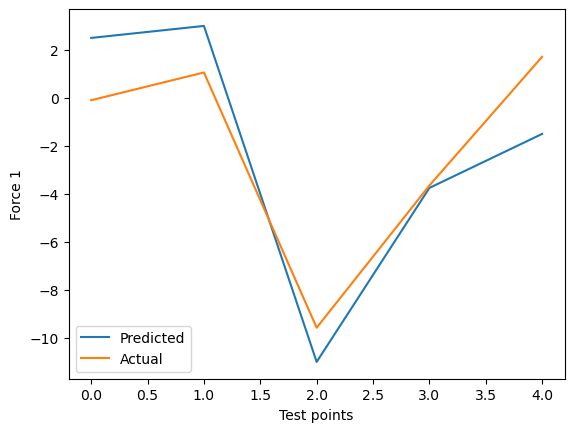

In [16]:
#Force 1 predictions of the test data
plt.plot(range(len(test_pred[1::idx])), test_pred[1::idx])
plt.plot(range(len(modified_test_y[1::idx])), modified_test_y[1::idx])
plt.xlabel("Test points")
plt.ylabel("Force 1")
plt.legend(["Predicted", "Actual"])
plt.show()

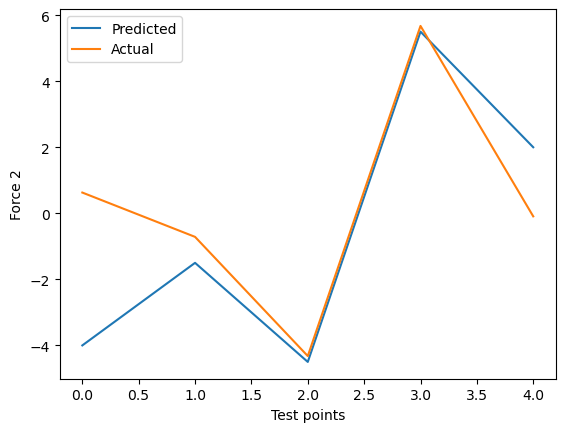

In [17]:
#Force 2 predictions of the test data
plt.plot(range(len(test_pred[2::idx])), test_pred[2::idx])
plt.plot(range(len(modified_test_y[2::idx])), modified_test_y[2::idx])
plt.xlabel("Test points")
plt.ylabel("Force 2")
plt.legend(["Predicted", "Actual"])
plt.show()

In [18]:
#RMSE for each output on the test data

rmse_e = np.sqrt(np.mean((test_pred[::idx] - modified_test_y[::idx])**2))
rmse_f1 = np.sqrt(np.mean((test_pred[1::idx] - modified_test_y[1::idx])**2))
rmse_f2 = np.sqrt(np.mean((test_pred[2::idx] - modified_test_y[2::idx])**2))

print("RMSE Energy: ", rmse_e)
print("RMSE Force 1: ", rmse_f1)
print("RMSE Force 2: ", rmse_f2)

RMSE Energy:  0.92376566
RMSE Force 1:  2.138645
RMSE Force 2:  2.3012714


### Conclusion

As we can see in the results above, the JAX implementation from scratch seems to perform worse than the RBFKernelGrad implementation. It could possibly be improved using a mean function.

One of the disadvantages of using gpytorch is that it doesn't provide a way to create custom powerful GP models. The JAX implementation from scratch is very powerful and flexible, but it is not as easy to use as gpytorch. I think it could be a good idea to create a library that provides a way to create custom GP models using JAX.

Some of the things I would like that can be tried in the future are:
1. Use dynamic mean functions to improve the performance of the model, if possible.
2. Use a different kernel approaches, e.g., Grid-structured kernel, to model the partial derivatives.
3. Since the current approach only works with small datastes, variational strategies might be better for scaling up the model with larger datasets.
4. It might be a good idea to try deep GPs, maybe in combination with variational approaches.